# Demonstration of stroke-lifetime

This notebook:
+ runs through the minimal amount of code to run the `stroke-lifetime` models.
+ describes what each result contains.
+ shows how to pick out the most useful results.
+ shows an example of running the code for multiple patients.

The code in a nutshell:
1. Load some fixed parameters (constant values).
2. Select the patient details. The models need to know the patient's age, sex, and mRS score on discharge from hospital following a stroke.
3. Pass the fixed parameters and patient details into a "main calculations" function.
4. Return a dictionary of the results.

For details about the maths behind how the results are calculated, look at:
+ [![Open in Streamlit][streamlit-img]][streamlit-link] The Streamlit app, which shows the method and an example for each main result.
+ The main methods paper, which is currently submitted but not yet published and linkable here (as of June 2024).

[streamlit-img]: https://static.streamlit.io/badges/streamlit_badge_black_white.svg
[streamlit-link]: https://lifetime-stroke-outcome.streamlit.app/


Some acronyms used in the code:

| Acronym | Meaning |
| --- | --- |
| LP | Linear Predictor |
| GZ | Gompertz model |
| QALY | Quality-Adjusted Life Year |
| AE | Accident & Emergency |
| NEL | Non-elective bed days |
| EL | Elective bed days |

### Separate-mRS vs dichotomous model

The exact same code is used to calculate results for discrete mRS values from 0 to 5 and to calculate results for a dichotomous regime.

In the dichotomous model, the mRS values are assigned a label:
+ mRS 0, 1, 2 are "independent"
+ mRS 3, 4, 5 are "dependent"

To find results for the "independent" group, set mRS to any of 0, 1, and 2. Any parameters that depend on mRS score are the same for all three mRS bands. Similarly for the "dependent" group, it doesn't matter whether the mRS is set to 3, 4, or 5.

The methods are exactly the same between the separate-mRS and the dichotomous models. The only differences are the fixed parameters that are used in the calculations.

### Installing the code

To install the `stroke-lifetime` package, run the following line in the terminal:

    pip install stroke-lifetime



## Setup for notebook

In [1]:
# Generic packages:
import pandas as pd              # Display tables nicely.
from numpy import ceil           # Round up a number.
import matplotlib.pyplot as plt  # Plotting.

In [2]:
# Imports for stroke-lifetime:

# Function to import fixed params for either mRS or dicho model:
from stroke_lifetime.fixed_params import get_fixed_params
# Main function for calculating lifetime results:
from stroke_lifetime.main_calculations import main_calculations

## 1. Load the fixed parameters

The fixed parameters are stored in a dictionary.

The dictionary is loaded via a function because the parameters used depend on whether we're using the separate-mRS or the dichotomous model.

Import both sets of fixed parameters and display them:

In [3]:
# Place fixed parameters in this DataFrame:
df_fixed_params = pd.DataFrame()
df_fixed_params['mRS'] = pd.Series(get_fixed_params('mRS'))
df_fixed_params['Dichotomous'] = pd.Series(get_fixed_params('Dichotomous'))

# Display the DataFrame in this roundabout way to view wider columns
# and so not cut off lists:
with pd.option_context('display.max_colwidth', 200):
    display(df_fixed_params)

,mRS,Dichotomous
time_max_post_discharge_year,50,50
qaly_age_coeff,0.000259,0.000259
qaly_age2_coeff,0.000033,0.000033
qaly_sex_coeff,0.021213,0.021213
discount_factor_QALYs_perc,3.5,3.5
discount_factor_costs_perc,3.5,3.5
wtp_qaly_gpb,20000,20000
cost_ae_gbp,170.46,170.46
cost_elective_bed_day_gbp,443.8,443.8
cost_non_elective_bed_day_gbp,532.56,532.56


## 2. Select the patient details

We need to select values for the following parameters:

| Parameter | Type | Comment |
| --- | --- | --- |
| age            | float or int. | Patient's age in years. |
| sex            | int. | Patient's sex, 0 for female and 1 for male. |
| sex_str        | str. | Either "Male" or "Female". |
| mrs            | int. | Patient's mRS score from 0 to 5. |
| fixed_params   | dict. | Contains fixed parameters independent of the model results. |
| model_type_str | str. | Separate "mRS" or "Dichotomous" model. |

Notes:
+ 'sex_str' and 'model_type_str' are not used in any calculation. They are stored in the results dictionary to make it clearer which parameters were used to calculate the results.


In [4]:
# Patient details:
age = 73
sex = 1
mrs = 0

# Convert the "sex" number into something easier to read.
sex_str = 'Male' if sex == 1 else 'Female'

# Select the model type ('mRS' or 'Dichotomous').
model_type_str = 'mRS'

# Reload the fixed parameters to make sure they match the model type:
fixed_params = get_fixed_params(model_type_str)

## 3. Main calculations function

Use the following function to calculate everything useful for displaying in the app. The function returns a dictionary of useful results.

In [5]:
results_dict = main_calculations(
    age,
    sex,
    sex_str,
    mrs,
    fixed_params,
    model_type_str
)

Later in this document there is an example for running this function with multiple patients.

## 4. Results dictionary details

The following tables show the contents of the results dictionary, what they mean, and how they are used.

__General:__

The results dictionary stores a copy of the inputs to the function:

| Key | dtype | Description | Use |
| --- | --- | --- | --- |
|    age            | `float` or `int` | Patient's age in years. | Parameter for models. |
|    sex            | `int` | Patient's sex, 0 for female and 1 for male. | Parameter for models. |
|    sex_str        | `str` | Either "Male" or "Female". | For reference only. |
|    mrs            | `int` | Patient's mRS score from 0 to 5. | Parameter for models. |
|    fixed_params   | `dict` | Contains fixed parameters independent of the model results. | Parameter for models. |
|    model_type_str | `str` | Separate "mRS" or "Dichotomous" model. | For reference only. |

__Mortality:__

| Key | dtype | Description | Use |
| --- | --- | --- | --- |
| death_in_year_1_lp | `float` | Linear Predictor for death in year 1. | Parameter for models. |
| death_in_year_1_prob | `float` | Probability of death in year 1 after stroke. | Result. |
| death_in_year_n_lp | `float` | Linear Predictor for death in any year "n". | Parameter for models. |
| years | `list` | The years used for any set of results given "by year". Ordinarily runs from 0 to 50 inclusive. | ~Result. |
| hazard_by_year | `list` | Hazard probabilities. All values are 1.0 minus "survival by year". Usually 50 values. | Result. |
| survival_by_year | `list` | Survival probabilities. All values are 1.0 minus "survival by year". Usually 50 values. | Result. |
| fhazard_by_year | `list` | Some intermediary step to calculating hazard probabilities. Usually 50 values. | Calculation step for models. |
| death_in_year_n_probs | `list` | Probability of death during (not "by") each year "n". Usually 50 values. | Result. |
| death_in_year_n_probs_first_invalid_index | `int` | The first index of `death_in_year_n_probs` that is below zero and should not be used. | ~Result. |
| survival_median_years | `float` | Median survival time in years. | Result. |
| survival_lower_quartile_years | `float` | Lower quartile survival time in years. | Result. |
| survival_upper_quartile_years | `float` | Upper quartile survival time in years. | Result. |
| life_expectancy | `float` | Life expectancy in years. This is the input age plus the median survival years. | Result. |
| year_when_zero_survival | `float` | The time after stroke when survival hits zero. This value is not necessarily a whole number of years. | Result. |


__QALYs:__

| Key | dtype | Description | Use |
| --- | --- | --- | --- |
| qalys_total | `float` | Sum of QALYs across each year post-stroke. | Result. |
| qalys_by_year | `list` | The QALY for each year of `survival_median_years`. The final value is scaled down to match the proportion of the year that the patient is alive for. | Result. |
| raw_qalys_by_year | `list` | The raw QALY for each year as above. The raw QALY is scaled to calculate the final QALY. | Calculation step for models. |


__Resources:__

| Key | dtype | Description | Use |
| --- | --- | --- | --- |
| ae_lp | `float` | Linear Predictor for model of A&E admissions. | Parameter for models. |
| ae_count | `float` | Total number of A&E admissions over the remaining lifetime. | Result. |
| ae_counts_by_year | `list` | Number of A&E admissions for each year over the remaining lifetime. | Calculation step for models. |
| ae_discounted_by_year | `list` | Cost of A&E admissions for each year over the remaining lifetime. | Calculation step for models. |
| ae_discounted_cost | `float` | Total cost of A&E admissions over the remaining lifetime. | Result. |
| nel_lp | `float` | Linear Predictor for model of non-elective bed days. | Parameter for models. |
| nel_count | `float` | Total number of non-elective bed days over the remaining lifetime. | Result. |
| nel_counts_by_year | `list` | Number of non-elective bed days for each year over the remaining lifetime. | Calculation step for models. |
| nel_discounted_by_year | `list` | Cost of non-elective bed days for each year over the remaining lifetime. | Calculation step for models. |
| nel_discounted_cost | `float` | Total cost of non-elective bed days over the remaining lifetime. | Result. |
| el_lp | `float` | Linear Predictor for model of elective bed days. | Parameter for models. |
| el_count | `float` | Total number of elective bed days over the remaining lifetime. | Result. |
| el_counts_by_year | `list` | Number of elective bed days for each year over the remaining lifetime. | Calculation step for models. |
| el_discounted_by_year | `list` | Cost of elective bed days for each year over the remaining lifetime. | Calculation step for models. |
| el_discounted_cost | `float` | Total cost of elective bed days over the remaining lifetime. | Result. |
| care_years | `float` | Total average time spent in residential care in years over the remaining lifetime. | Result. |
| care_years_by_year | `list` | Average time spent in residential care each year over the remaining lifetime. | Calculation step for models. |
| care_years_discounted_by_year | `list` | Cost of average time spent in residential care each year over the remaining lifetime. | Calculation step for models. |
| care_years_discounted_cost | `float` | Total cost of time spent in residential care over the remaining lifetime. | Result. |
| total_discounted_cost | `float` | Total combined cost of A&E use, NEL days, EL days, and time in residential care, all over the remaining lifetime. | Result. |

__Cost:__

| Key | dtype | Description | Use |
| --- | --- | --- | --- |
| net_benefit | `float` | Net cost benefit, which are QALYs valued at the Willingness to Pay (WTP) threshold. | Result. |



Notes:
+ Most "mortality" lists have 50 entries because by default the calculations are done for 50 years post-stroke.
+ Most "QALY" and "resource use" lists have one entry for each year in the remaining lifetime (rounded up).

In this case the median survival years (remaining lifetime) is:

In [6]:
results_dict['survival_median_years']

10.702454420630898

... and so the number of entries in some lists is this value rounded up:

In [7]:
ceil(results_dict['survival_median_years'])

11.0

## 5. Example usage of the outputs

The following cells show how to make a basic recreation of each part of the Streamlit app.

### Mortality

Survival over time:

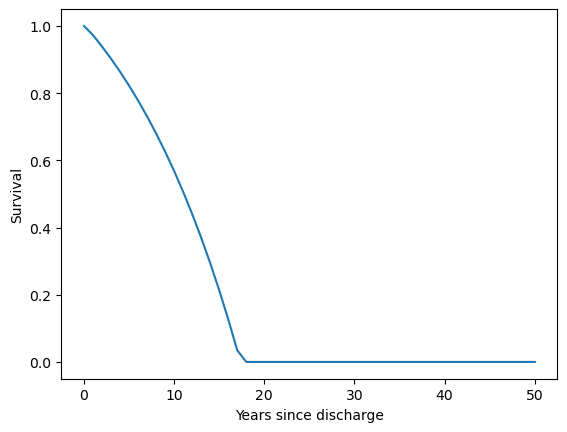

In [8]:
fig, ax = plt.subplots()

ax.plot(results_dict['years'], results_dict['survival_by_year'])
ax.set_xlabel('Years since discharge')
ax.set_ylabel('Survival')

plt.show()

Hazard function:

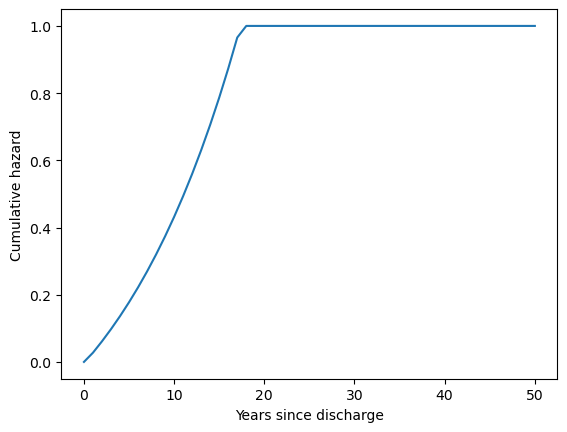

In [9]:
fig, ax = plt.subplots()

ax.plot(results_dict['years'], results_dict['hazard_by_year'])
ax.set_xlabel('Years since discharge')
ax.set_ylabel('Cumulative hazard')

plt.show()

Probability of death:

In [10]:
pDeath = pd.DataFrame(
    [results_dict['years'][1:], results_dict['death_in_year_n_probs']],
    index=['Year', 'Probability of death during this year']
).T.set_index('Year')

# Only show a few values:
pDeath.head(5)

,Probability of death during this year
Year,
1.0,0.027442
2.0,0.033306
3.0,0.035568
4.0,0.037981
5.0,0.040553


Survival table

In [11]:
print(f"Median survival (years): {results_dict['survival_median_years']:6.3f}")
print(f"Lower IQR (years):       {results_dict['survival_lower_quartile_years']:6.3f}")
print(f"Upper IQR (years):       {results_dict['survival_upper_quartile_years']:6.3f}")
print(f"Life expectancy (age):   {results_dict['life_expectancy']:6.3f}")

Median survival (years): 10.702
Lower IQR (years):        6.350
Upper IQR (years):       14.070
Life expectancy (age):   83.702


## QALYS

Discounted QALYs table:

In [12]:
print(f"Utility:                 {fixed_params['utility_list'][mrs]:6.3f}")
print(f"Median survival (years): {results_dict['survival_median_years']:6.3f}")
print(f"Lower IQR (years):       {results_dict['survival_lower_quartile_years']:6.3f}")
print(f"Upper IQR (years):       {results_dict['survival_upper_quartile_years']:6.3f}")
print(f"QALYs:                   {results_dict['qalys_total']:6.3f}")

Utility:                  0.950
Median survival (years): 10.702
Lower IQR (years):        6.350
Upper IQR (years):       14.070
QALYs:                    8.360


## Resources and costs

Resource use table:

In [13]:
print(f"A&E:                                      {results_dict['ae_count']:6.3f}")
print(f"NEL days:                                 {results_dict['nel_count']:6.3f}")
print(f"EL days:                                  {results_dict['el_count']:6.3f}")
print(f"Average time in residential care (years): {results_dict['care_years']:6.3f}")

A&E:                                       7.042
NEL days:                                 21.987
EL days:                                   1.649
Average time in residential care (years):  0.081


Discounted cost of resource use table:

In [14]:
print(f"A&E:                     £{results_dict['ae_discounted_cost']:9.2f}")
print(f"NEL days:                £{results_dict['nel_discounted_cost']:9.2f}")
print(f"EL days:                 £{results_dict['el_discounted_cost']:9.2f}")
print(f"Cost of residental care: £{results_dict['care_years_discounted_cost']:9.2f}")
print(f"Total cost:              £{results_dict['total_discounted_cost']:9.2f}")

A&E:                     £  1040.35
NEL days:                £ 10821.57
EL days:                 £   643.30
Cost of residental care: £  2573.77
Total cost:              £ 15078.99


## Cost-effectiveness

In the app a table of difference of net benefit for different mRS bands is shown. The values behind the table (without differences) are:

In [15]:
print(f"Net benefit: £{results_dict['net_benefit']:9.2f}")

Net benefit: £152112.34


## 6. Running multiple patients

The `main_calculations()` function has to be run separately for each patient.

For example, with patient details stored in a DataFrame:

In [16]:
age_range = range(75, 77, 1)
model_type_str = 'mRS'

# Decide which mRS scores to run:
if model_type_str == 'mRS':
    mrs_to_run = range(6)
else:
    # In the dichotomous model we give one set of parameters to
    # mRS < 3 and a second set to mRS >=3. So just run two mRS
    # values to save repeats.
    mrs_to_run = [0, 5]


# Store patients in here:
patient_df = pd.DataFrame(columns=[
    'age', 'sex', 'sex_label', 'mrs', 'outcome_type'])
count = 0
for age in age_range:
    for sex in [0, 1]:
        sex_label = 'Male' if sex == 1 else 'Female'
        for mrs in mrs_to_run:
            # Use the mRS score to label this patient as independent or
            # dependent in the dichotomous model.
            outcome_type = 'Dependent' if mrs > 2 else 'Independent'

            patient_df.loc[count] = [
                age, sex, sex_label, mrs, outcome_type]
            count += 1

In [17]:
# Only show a few values:
patient_df.head(5)

,age,sex,sex_label,mrs,outcome_type
0,75,0,Female,0,Independent
1,75,0,Female,1,Independent
2,75,0,Female,2,Independent
3,75,0,Female,3,Dependent
4,75,0,Female,4,Dependent


The main calculations function can be looped over like this:

In [18]:
# Get the fixed parameters dictionary.
# This is found via a function because the parameters used
# depend on whether we're using the separate-mRS or the dichotomous
# model.
fixed_params = get_fixed_params(model_type_str)

# Store results dictionaries in here:
results_dict_list = []

# Run each patient separately:
for p in range(len(patient_df)):
    patient = patient_df.loc[p]

    # This is the same code as in "2_Interactive_demo.py".
    results_dict = main_calculations(
        patient['age'],
        patient['sex'],
        patient['sex_label'],
        patient['mrs'],
        fixed_params,
        model_type_str
        )
    # Store this dictionary in the list of dicts:
    results_dict_list.append(results_dict)

# Turn all results dictionaries into a single data frame:
df = pd.DataFrame(results_dict_list)

In [19]:
# Only show a few values:
df.head(3).T

,0,1,2
age,75,75,75
sex,0,0,0
sex_label,Female,Female,Female
model_type,mRS,mRS,mRS
mrs,0,1,2
outcome_type,Independent,Independent,Independent
death_in_year_1_lp,-3.710982,-2.816063,-2.834336
death_in_year_1_prob,0.02387,0.056462,0.055497
death_in_year_n_lp,-9.211526,-9.093642,-8.675869
years,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
